# Librerías

In [1]:
import itertools
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)#Prueba evaluación y entrenamiento un solo individuo. 
#Vectores completos
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import random

In [29]:
import seaborn as sns

# Databases

In [2]:
#Reading all the cvs
#Nss learning
nsl_training=pd.read_csv('./Final_Datasets/MINMAX_FD_NSL_Tra.csv')
#Nsl testing
nsl_testing=pd.read_csv('./Final_Datasets/MINMAX_FD_NSL_Test.csv')

# Labels

In [3]:
#NSL TESTING LABELS

#Index binary (2 clases)
L_nsl_testing_indexbinary=pd.read_csv("./Final_Datasets/L_nsl_testing_indexbinary.csv")
#Index by Group (5 clases)
L_nsl_testing_indexbygroup=pd.read_csv("./Final_Datasets/L_nsl_testing_indexbygroup.csv")
#Index tipe of attack (42? clases)
L_nsl_testing_indextipeofattack=pd.read_csv("./Final_Datasets/L_nsl_testing_indextipeofattack.csv")


#nsl TRAINING LABELS
# 2 clases
L_nsl_training_indexbinary=pd.read_csv("./Final_Datasets/L_nsl_training_indexbinary.csv")
#Index by Group (5 clases)
L_nsl_training_indexbygroup=pd.read_csv("./Final_Datasets/L_nsl_training_indexbygroup.csv")
#Index tipe of attack (42? clases)
L_nsl_training_indextipeofattack=pd.read_csv("./Final_Datasets/L_nsl_training_indextipeofattack.csv")

# Conversión de Pandas->Numpy (array) not Matrix

In [4]:
nsl_training=nsl_training.as_matrix(columns=None)
nsl_testing=nsl_testing.as_matrix(columns=None)

# Lectura del modelo

In [5]:
from sklearn.ensemble import RandomForestClassifier

modelo=RandomForestClassifier(criterion='entropy',n_jobs=2, 
                              bootstrap=True, max_depth=10, max_features='sqrt', min_samples_leaf=2, 
                              min_samples_split=100, n_estimators=8)


# Creacion de las funciones a utilizar

# funcion muta vector binario corregida

In [6]:
def muta_vector_binario(dimensiones_temporales,M=20):
    """Dimensiones temporales: vector binario que contiene las dimensiones actuales de la ultima
        iteración probada.
        M=cantidad total de dimensiones a mutar. Si no se otorga un número
        M es igual a la máxima cantidad de dimensiones en NSL-KDD"""
    
    print("Valor de M (dimensiones a mutar): %s" %M)
    vector_mutado=np.array(dimensiones_temporales)
    #Genera números aleatorios entre 0 y M
    #Dichos numeros aleatorios seran los indices a mutar de (vector_mutado)
    indice_general=list(range(0,40))
    indice=sorted(random.sample(indice_general,M))
    
   
    #Aplica la operación negación binaria a los valores del indice
    for numero_indice in indice:
        if vector_mutado[numero_indice]==0:
            vector_mutado[numero_indice]=1
        else:
            vector_mutado[numero_indice]=0
    #regresa el vector mutado
    print("indice de vectores a mutar: ")
    print(indice)
    print("Solución actual:")
    print(dimensiones_temporales)
    print("Solución mutada:")
    print(vector_mutado)
    print("\n")
    return vector_mutado
    

In [7]:
def obtencion_parametros_binarios(vector_actual, M=40):
    """M=máximo número de dimensiones a mutar
    vector_actual= vector binario, relacionado con la ultima iteracion
    puede o no ser el mejor.
    Regresa los zeros y unos actuales,
    el ultimo vector binario,
    los dataset filtrados"""

    #Agregar la función para calcular M

    
    #Muta el ultimo vector
    dimensiones_temporales=muta_vector_binario(vector_actual,M)

    #se filtra la base de datos con las dimensiones de dimensiones mejor
    #SE hacen cero las dimensiones a omitir
    #dimensiones_temporales contiene la mejor iteración, entonces es la dimensión activa
    training=nsl_training*dimensiones_temporales
    testing=nsl_testing*dimensiones_temporales

    #Se buscan esos ceros en el indice (dimensiones suspendidas)
    zeros=np.where(dimensiones_temporales == 0)

    #se obtienen los indices del los unos (dimensiones activas)
    unos=np.where(dimensiones_temporales==1)

    #se eliminan esas dimensiones
    training=np.delete(training,zeros,axis=1)
    testing=np.delete(testing,zeros,axis=1)

    
    return [dimensiones_temporales,zeros,unos,training,testing]

# Funcion para calcular M dependiendo de las iteraciones

In [8]:
def M_dimensiones_a_mutar(Perror,i_actual,i_max,M_Max=40):
    iteraciones=1-(i_actual/i_max)
    M=M_Max*np.amin([iteraciones,Perror])
    M=np.array(np.round_(M))
    return M

In [9]:
def M_dimensiones_a_mutar_2(i_actual,i_max,M_Max=40):
    iteraciones=1-(i_actual/i_max)
    M=M_Max*iteraciones
    M=np.array(np.round_(M))
    return M

# Declaración del modelo

In [10]:
from sklearn.ensemble import RandomForestClassifier

modelo=RandomForestClassifier(criterion='entropy',n_jobs=2, 
                              bootstrap=True, max_depth=10, max_features='sqrt', min_samples_leaf=2, 
                              min_samples_split=100, n_estimators=8)


# Función de rendimiento

In [11]:
def funcion_rendimiento(Perror_actual,unos,N=40,alfa=.3):
    cardinalidad=np.array(unos).shape[1]
    rendimiento=alfa*Perror_actual+(1-alfa)*(cardinalidad/N)
    return rendimiento

# Inicio del algoritmo RMHC

## Prueba con unicametne Perror sin contemplar el Rendimiento (RE)

In [23]:
i=0
M=38
iteraciones_maximas=500
#la declaracion tiene que ser 40! cómo puede tener menos dimensinoes???!!!
mejor_solucion=np.random.randint(2, size=40)
#almacena los score de todas las iteraciones
registro_score_iteracion=[]
#almacena la probabilidad de error de todas las iteraciones
registro_perror_iteracion=[]
#almacena el vector binario de todas las iteraciones
registro_dimensiones_iteracion=[]
#registro de la probabilidad de error de los valores aceptados
registro_perror_valores_aceptados=[]
#almacena unicamente el score de los vectores binarios aceptados
registro_score_valores_aceptados=[]
#almacena el vector binario de los valores aceptados (dimensiones_activas)
#es un sinonimo de la mejor solucion del espacio de búsqueda
registro_dimensiones_activas_valores_aceptados=[]
#registro de las dimensiones activas por iteracion
registro_dimensiones_activas_iteracion=[]
#registro de la cantidad de dimensiones activas por iteracion
registro_cantidad_dimensiones_activas_iteracion=[]
#registro cantidad de dimensiones activas de los valores aceptados
registro_cantidad_dimensiones_activas_aceptados=[]

#registro del rendimiento por iteracion
registro_rendimiento_iteracion=[]
#registro del rendimiento de los valore aceptados
registro_rendimiento_aceptados=[]



print("solucion_inicial")
print(mejor_solucion)
print("\n")


#evaluacion de los primeros parametros para la PRIMER solucion
#la cual se considera la mejor
mejor_solucion=np.random.randint(2, size=40)


#dimensiones temporales se omite porque YA genera el siguiente vector.
[dimensiones_temporales,zeros,unos,training,testing]=obtencion_parametros_binarios(mejor_solucion,M)
modelo.fit(training,L_nsl_training_indexbinary.values.ravel())
predicciones=modelo.predict(testing)
mejor_score=accuracy_score(L_nsl_testing_indexbinary,predicciones)
mejor_perror=1-mejor_score
mejor_rendimiento=funcion_rendimiento(mejor_perror,unos,N=40,alfa=.3)



registro_score_valores_aceptados.append(mejor_score)
registro_perror_valores_aceptados.append(mejor_perror)
registro_dimensiones_activas_valores_aceptados.append(mejor_solucion)
registro_cantidad_dimensiones_activas_aceptados.append(np.array(unos).shape[1])
registro_rendimiento_aceptados.append(mejor_rendimiento)

while (i<iteraciones_maximas):
    print("\n\n Iteracion: %s \n\n" %(i+1))
    
    #desde el inicio genera el siguiente vector binario partiendo que el mejor fue el primero generado.
    #dimensinoes temporales es el vector binario que va mutando con cada iteración
    [dimensiones_temporales,zeros,unos,training,testing]=obtencion_parametros_binarios(dimensiones_temporales,M)    
    #Se evaluan los resultados
    #se entrena el modelo
    modelo.fit(training,L_nsl_training_indexbinary.values.ravel())
    #se obtienen las predicciones
    predicciones=modelo.predict(testing)

    #se obtiene el accuracy score
    score_actual=accuracy_score(L_nsl_testing_indexbinary,predicciones)
    #se obtiene la probabilidad de error
    perror_actual=1-score_actual
    #se obtiene el rendimiento de dicha solucion
    rendimiento_actual=funcion_rendimiento(perror_actual,unos,N=40,alfa=.3)
    
    
    
    #se declara un vector que contiene todos los score de todas las iteraciones

    #Se almacenan los resultados
    registro_score_iteracion.append(score_actual)
    registro_dimensiones_iteracion.append(dimensiones_temporales)
    registro_perror_iteracion.append(perror_actual)
    registro_dimensiones_activas_iteracion.append(unos)
    registro_cantidad_dimensiones_activas_iteracion.append(np.array(unos).shape[1])
    registro_rendimiento_iteracion.append(rendimiento_actual)
    
    
    #aqui entra el If
    if rendimiento_actual < mejor_rendimiento:
        #se actualiza la mejor solucion del espacio de búsqueda
        mejor_solucion=np.array(dimensiones_temporales)
        print("\n Se encontró una mejor solución \n")
        print("Score mejor anterior: %s" %mejor_score)
        mejor_score=score_actual
        print("Score mejor actual: %s" %mejor_score)
        print("Rendimiento anterior: %s" %mejor_rendimiento)
        print("Rendimiento actual: %s" %rendimiento_actual)
        mejor_rendimiento=np.array(rendimiento_actual)
        
        print("Cantidad de Dimensiones activas anteriores: %s" %(
            registro_cantidad_dimensiones_activas_aceptados[-1]))
        #np.array(registro_dimensiones_activas_iteracion[-1]).shape[1]
        print("Cantidad de Dimensiones activas actuales: %s" %np.array(unos).shape[1])
        
        
        
        
        #impresion de parametros
        registro_score_valores_aceptados.append(mejor_score)
        registro_perror_valores_aceptados.append(perror_actual)
        registro_dimensiones_activas_valores_aceptados.append(dimensiones_temporales)
        registro_rendimiento_aceptados.append(rendimiento_actual)
        registro_cantidad_dimensiones_activas_aceptados.append(np.array(unos).shape[1])
    
    
    #Se imprimen los resultados
    print("Indice de las Dimensiones activas: ")
    print(unos)
    print("Total de dimensiones activas: %s" % np.array(unos).shape[1])
    print("Porcentaje de exactitud: %s (accuracy score)" %accuracy_score(L_nsl_testing_indexbinary,predicciones))
    print("Probabilidad de error (Perror): %s" % (1-accuracy_score(L_nsl_testing_indexbinary,predicciones)))
    print("Rendimiento (RE): %s" %rendimiento_actual)
    
    
    
    
    
    #M se calcula al final
    
    #M=M_dimensiones_a_mutar_2(i,iteraciones_maximas,M_Max=40)
    
    M=M_dimensiones_a_mutar(perror_actual,i,iteraciones_maximas,M_Max=40)
    
    
    #M debe ser entero o da un error al elegir el sampleo aleatorio en la seleccion de dimensiones
    #problema porque M es flotante
    M=int(M)
   
    
    i=i+1
    

solucion_inicial
[0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0
 1 1 1]


Valor de M (dimensiones a mutar): 38
indice de vectores a mutar: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39]
Solución actual:
[1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1
 0 1 1]
Solución mutada:
[0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 1 0 0 0
 1 0 0]




 Iteracion: 1 


Valor de M (dimensiones a mutar): 38
indice de vectores a mutar: 
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Solución actual:
[0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 1 0 0 0
 1 0 0]
Solución mutada:
[1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 1
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2, 


 Se encontró una mejor solución 

Score mejor anterior: 0.75105354212
Score mejor actual: 0.78214966952
Rendimiento anterior: 0.372183937364
Rendimiento actual: 0.345355099144
Cantidad de Dimensiones activas anteriores: 17
Cantidad de Dimensiones activas actuales: 16
Indice de las Dimensiones activas: 
(array([ 1,  3,  4,  9, 10, 14, 17, 20, 21, 25, 27, 29, 31, 32, 37, 38]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.78214966952 (accuracy score)
Probabilidad de error (Perror): 0.21785033048
Rendimiento (RE): 0.345355099144


 Iteracion: 14 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[2, 10, 11, 14, 19, 25, 32, 36, 38]
Solución actual:
[0 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0
 1 1 0]
Solución mutada:
[0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1
 1 0 0]



 Se encontró una mejor solución 

Score mejor anterior: 0.78214966952
Score mejor actual: 0.774963403274
Rendimiento anterior: 0

Indice de las Dimensiones activas: 
(array([ 1,  2,  5,  6,  7, 12, 13, 15, 17, 18, 19, 21, 22, 23, 24, 25, 27,
       31, 32, 33, 38]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.736725369294 (accuracy score)
Probabilidad de error (Perror): 0.263274630706
Rendimiento (RE): 0.446482389212


 Iteracion: 26 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[1, 2, 21, 23, 25, 27, 33, 34, 37, 38, 39]
Solución actual:
[0 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1 1 1 0 0 0
 0 1 0]
Solución mutada:
[0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 5,  6,  7, 12, 13, 15, 17, 18, 19, 22, 24, 31, 32, 34, 37, 39]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.737168965976 (accuracy score)
Probabilidad de error (Perror): 0.262831034024
Rendimiento (RE): 0.358849310207


 Iteracion: 27 


Valor de M (dimensiones a mutar): 11
indice de vectores a mu

Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  5,  8,  9, 10, 12, 14, 15, 16, 17, 19, 23, 25, 27,
       28, 30, 37, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.786230758994 (accuracy score)
Probabilidad de error (Perror): 0.213769241006
Rendimiento (RE): 0.449130772302


 Iteracion: 40 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[3, 7, 10, 12, 23, 27, 29, 31, 33]
Solución actual:
[0 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0
 1 1 1]
Solución mutada:
[0 1 1 0 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 1,  2,  4,  5,  7,  8,  9, 14, 15, 16, 17, 19, 25, 28, 29, 30, 31,
       33, 37, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.758062369693 (accuracy score)
Probabilidad de error (Perror): 0.241937630307
Rendimiento (RE): 0.440081289092


 Iteracion: 41 


Valor de M (dimensiones a mutar): 10
i

Indice de las Dimensiones activas: 
(array([ 0,  2,  4,  6,  8,  9, 14, 15, 19, 21, 22, 24, 28, 29, 32, 37, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.744621390232 (accuracy score)
Probabilidad de error (Perror): 0.255378609768
Rendimiento (RE): 0.37411358293


 Iteracion: 54 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 6, 10, 13, 17, 22, 26, 28, 38, 39]
Solución actual:
[1 0 1 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0
 1 0 1]
Solución mutada:
[1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  2,  4,  8,  9, 10, 13, 14, 15, 17, 19, 21, 24, 26, 29, 32,
       37, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.756110544293 (accuracy score)
Probabilidad de error (Perror): 0.243889455707
Rendimiento (RE): 0.405666836712


 Iteracion: 55 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[3,

Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  5,  6, 10, 11, 12, 14, 15, 16, 17, 19, 23, 25, 27, 29,
       31, 33, 35, 36, 37, 38]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.743334959855 (accuracy score)
Probabilidad de error (Perror): 0.256665040145
Rendimiento (RE): 0.479499512044


 Iteracion: 67 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[3, 4, 9, 11, 14, 21, 29, 31, 35, 36]
Solución actual:
[1 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1
 1 1 0]
Solución mutada:
[1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  5,  6,  9, 10, 12, 15, 16, 17, 19, 21, 23, 25, 27, 33,
       37, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.767067382336 (accuracy score)
Probabilidad de error (Perror): 0.232932617664
Rendimiento (RE): 0.402379785299


 Iteracion: 68 


Valor de M (dimensiones a mutar): 9
in

Indice de las Dimensiones activas: 
(array([ 2,  5,  8, 11, 13, 16, 18, 20, 21, 23, 24, 25, 26, 27, 30, 31, 35,
       36, 37, 38]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.779133212084 (accuracy score)
Probabilidad de error (Perror): 0.220866787916
Rendimiento (RE): 0.416260036375


 Iteracion: 81 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[2, 5, 8, 12, 14, 17, 22, 31, 36]
Solución actual:
[0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1
 1 1 0]
Solución mutada:
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([11, 12, 13, 14, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 30, 35,
       37, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.755400789602 (accuracy score)
Probabilidad de error (Perror): 0.244599210398
Rendimiento (RE): 0.405879763119


 Iteracion: 82 


Valor de M (dimensiones a mutar): 10
indice de vectores

Indice de las Dimensiones activas: 
(array([ 0,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 21, 24, 26, 29, 30,
       32, 34, 35, 37, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.726433926274 (accuracy score)
Probabilidad de error (Perror): 0.273566073726
Rendimiento (RE): 0.467069822118


 Iteracion: 94 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[0, 2, 5, 17, 18, 19, 20, 23, 31, 34, 38]
Solución actual:
[1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 1 0
 1 0 1]
Solución mutada:
[0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 2,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23,
       24, 26, 29, 30, 31, 32, 35, 37, 38, 39]),)
Total de dimensiones activas: 27
Porcentaje de exactitud: 0.761034467462 (accuracy score)
Probabilidad de error (Perror): 0.238965532538
Rendimiento (RE): 0.544189659761


 Iteracion: 95 


Valor 

Indice de las Dimensiones activas: 
(array([ 0,  4,  5,  7,  8,  9, 10, 14, 15, 18, 22, 23, 25, 28, 33, 34, 35,
       37, 38, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.733354034512 (accuracy score)
Probabilidad de error (Perror): 0.266645965488
Rendimiento (RE): 0.429993789646


 Iteracion: 107 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[4, 5, 8, 10, 12, 13, 19, 20, 33, 34, 37]
Solución actual:
[1 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 0
 1 1 1]
Solución mutada:
[1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  7,  9, 12, 13, 14, 15, 18, 19, 20, 22, 23, 25, 28, 35, 38, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.731490928448 (accuracy score)
Probabilidad de error (Perror): 0.268509071552
Rendimiento (RE): 0.378052721466


 Iteracion: 108 


Valor de M (dimensiones a mutar): 11
indice de vectores a m

Indice de las Dimensiones activas: 
(array([ 1,  3,  5,  6,  7,  9, 11, 13, 14, 15, 17, 20, 23, 25, 27, 31, 32,
       37, 38, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.757884931021 (accuracy score)
Probabilidad de error (Perror): 0.242115068979
Rendimiento (RE): 0.422634520694


 Iteracion: 121 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[6, 8, 16, 18, 21, 22, 30, 31, 34, 39]
Solución actual:
[0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0
 1 1 1]
Solución mutada:
[0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 1,  3,  5,  7,  8,  9, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23,
       25, 27, 30, 32, 34, 37, 38]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.782637625871 (accuracy score)
Probabilidad de error (Perror): 0.217362374129
Rendimiento (RE): 0.485208712239


 Iteracion: 122 


Valor de M (dimensiones a m

Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  5,  8,  9, 11, 14, 20, 21, 24, 27, 31, 32, 34, 35, 36,
       37, 38]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.764938118263 (accuracy score)
Probabilidad de error (Perror): 0.235061881737
Rendimiento (RE): 0.403018564521


 Iteracion: 135 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[4, 5, 14, 20, 21, 22, 27, 28, 30]
Solución actual:
[1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 1 1 1
 1 1 0]
Solución mutada:
[1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  8,  9, 11, 22, 24, 28, 30, 31, 32, 34, 35, 36, 37, 38]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.759969835426 (accuracy score)
Probabilidad de error (Perror): 0.240030164574
Rendimiento (RE): 0.352009049372


 Iteracion: 136 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[2, 9, 16

Indice de las Dimensiones activas: 
(array([ 2,  6,  8,  9, 10, 11, 12, 14, 15, 18, 19, 21, 23, 24, 27, 29, 30,
       32, 34, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.737967440004 (accuracy score)
Probabilidad de error (Perror): 0.262032559996
Rendimiento (RE): 0.428609767999


 Iteracion: 148 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 3, 5, 9, 12, 17, 22, 25, 31, 32]
Solución actual:
[0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0
 0 0 1]
Solución mutada:
[1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  5,  6,  8, 10, 11, 14, 15, 17, 18, 19, 21, 22, 23, 24,
       25, 27, 29, 30, 31, 34, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.756465421639 (accuracy score)
Probabilidad de error (Perror): 0.243534578361
Rendimiento (RE): 0.493060373508


 Iteracion: 149 


Valor de M (dimensiones a mut

Indice de las Dimensiones activas: 
(array([ 0,  5,  6,  7, 13, 15, 16, 17, 20, 21, 22, 25, 26, 29, 31, 32, 33,
       34, 35, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.714989131881 (accuracy score)
Probabilidad de error (Perror): 0.285010868119
Rendimiento (RE): 0.453003260436


 Iteracion: 162 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[5, 7, 8, 9, 12, 13, 17, 22, 24, 27, 30]
Solución actual:
[1 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0
 0 1 1]
Solución mutada:
[1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  6,  8,  9, 12, 15, 16, 20, 21, 24, 25, 26, 27, 29, 30, 31, 32,
       33, 34, 35, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.733620192521 (accuracy score)
Probabilidad de error (Perror): 0.266379807479
Rendimiento (RE): 0.464913942244


 Iteracion: 163 


Valor de M (dimensiones a mut

Indice de las Dimensiones activas: 
(array([ 1,  4,  6, 10, 11, 12, 13, 15, 17, 19, 20, 22, 24, 26, 28, 29, 31,
       33, 34, 37, 38]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.767865856363 (accuracy score)
Probabilidad de error (Perror): 0.232134143637
Rendimiento (RE): 0.437140243091


 Iteracion: 176 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 1, 5, 7, 9, 12, 14, 20, 30]
Solución actual:
[0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0
 1 1 0]
Solución mutada:
[1 0 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  4,  5,  6,  7,  9, 10, 11, 13, 14, 15, 17, 19, 22, 24, 26, 28,
       29, 30, 31, 33, 34, 37, 38]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.781617353502 (accuracy score)
Probabilidad de error (Perror): 0.218382646498
Rendimiento (RE): 0.485514793949


 Iteracion: 177 


Valor de M (dimensiones a mutar

Indice de las Dimensiones activas: 
(array([ 0,  3,  5,  6,  7,  9, 10, 13, 21, 22, 23, 26, 27, 28, 29, 30, 33,
       34, 37, 38]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.766135829304 (accuracy score)
Probabilidad de error (Perror): 0.233864170696
Rendimiento (RE): 0.420159251209


 Iteracion: 189 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 4, 5, 7, 17, 23, 28, 35, 38]
Solución actual:
[1 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0
 1 1 0]
Solución mutada:
[1 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  4,  6,  9, 10, 13, 17, 21, 22, 26, 27, 29, 30, 33, 34,
       35, 37]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.752872288515 (accuracy score)
Probabilidad de error (Perror): 0.247127711485
Rendimiento (RE): 0.406638313445


 Iteracion: 190 


Valor de M (dimensiones a mutar): 10
indice de vectore

Indice de las Dimensiones activas: 
(array([ 1,  4,  8,  9, 10, 11, 15, 16, 17, 19, 28, 30, 31, 32, 37, 38]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.768353812713 (accuracy score)
Probabilidad de error (Perror): 0.231646187287
Rendimiento (RE): 0.349493856186


 Iteracion: 202 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[3, 8, 9, 13, 16, 20, 28, 30, 35]
Solución actual:
[0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0
 1 1 0]
Solución mutada:
[0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 1,  3,  4, 10, 11, 13, 15, 17, 19, 20, 31, 32, 35, 37, 38]),)
Total de dimensiones activas: 15
Porcentaje de exactitud: 0.779931686111 (accuracy score)
Probabilidad de error (Perror): 0.220068313889
Rendimiento (RE): 0.328520494167


 Iteracion: 203 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 9, 17, 24, 27, 30, 31, 32, 39]

Indice de las Dimensiones activas: 
(array([ 4,  7,  9, 10, 11, 12, 16, 18, 22, 24, 25, 26, 28, 31, 32, 33, 34,
       35, 36, 37, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.736059974271 (accuracy score)
Probabilidad de error (Perror): 0.263940025729
Rendimiento (RE): 0.446682007719


 Iteracion: 215 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[2, 4, 9, 12, 16, 19, 20, 22, 27, 28, 30]
Solución actual:
[0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1
 1 0 1]
Solución mutada:
[0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 2,  7, 10, 11, 18, 19, 20, 24, 25, 26, 27, 30, 31, 32, 33, 34, 35,
       36, 37, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.744843188573 (accuracy score)
Probabilidad de error (Perror): 0.255156811427
Rendimiento (RE): 0.426547043428


 Iteracion: 216 


Valor de M (dimensiones a mutar): 10

Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  6,  7,  8, 10, 11, 13, 17, 18, 19, 21, 23, 25, 28,
       31, 32]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.777624983365 (accuracy score)
Probabilidad de error (Perror): 0.222375016635
Rendimiento (RE): 0.39921250499


 Iteracion: 228 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[8, 13, 18, 22, 24, 25, 27, 29, 33]
Solución actual:
[0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0
 0 0 0]
Solución mutada:
[0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 0
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 1,  2,  3,  4,  6,  7, 10, 11, 17, 19, 21, 22, 23, 24, 27, 28, 29,
       31, 32, 33]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.749190436056 (accuracy score)
Probabilidad de error (Perror): 0.250809563944
Rendimiento (RE): 0.425242869183


 Iteracion: 229 


Valor de M (dimensiones a mutar): 10
indice de vecto

Indice de las Dimensiones activas: 
(array([ 0,  2,  4,  5,  6,  7,  8, 10, 12, 16, 20, 21, 27, 30, 31, 32, 35,
       37]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.773854411569 (accuracy score)
Probabilidad de error (Perror): 0.226145588431
Rendimiento (RE): 0.382843676529


 Iteracion: 242 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[2, 3, 6, 15, 21, 22, 26, 32, 35]
Solución actual:
[1 0 1 0 1 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0
 1 0 0]
Solución mutada:
[1 0 0 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  3,  4,  5,  7,  8, 10, 12, 15, 16, 20, 22, 26, 27, 30, 31, 37]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.765692232622 (accuracy score)
Probabilidad de error (Perror): 0.234307767378
Rendimiento (RE): 0.367792330213


 Iteracion: 243 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[5, 6, 9, 1

Indice de las Dimensiones activas: 
(array([ 1,  3,  8,  9, 10, 12, 16, 18, 19, 22, 24, 25, 29, 31, 32, 33, 37,
       38, 39]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.734640464889 (accuracy score)
Probabilidad de error (Perror): 0.265359535111
Rendimiento (RE): 0.412107860533


 Iteracion: 255 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[0, 3, 8, 11, 22, 23, 26, 27, 28, 29, 32]
Solución actual:
[0 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 0
 1 1 1]
Solución mutada:
[1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 1 0 0 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  9, 10, 11, 12, 16, 18, 19, 23, 24, 25, 26, 27, 28, 31, 33,
       37, 38, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.75495719292 (accuracy score)
Probabilidad de error (Perror): 0.24504280708
Rendimiento (RE): 0.423512842124


 Iteracion: 256 


Valor de M (dimensiones a mutar): 10
indice de

Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  5,  7, 13, 15, 16, 17, 23, 25, 26, 29, 30, 33, 34, 35,
       36, 37, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.751718937142 (accuracy score)
Probabilidad de error (Perror): 0.248281062858
Rendimiento (RE): 0.441984318857


 Iteracion: 268 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[4, 7, 8, 13, 18, 21, 24, 26, 32, 37]
Solución actual:
[1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1
 1 1 1]
Solución mutada:
[1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  4,  5,  8, 15, 16, 17, 18, 21, 23, 24, 25, 29, 30, 32,
       33, 34, 35, 36, 38, 39]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.781484274498 (accuracy score)
Probabilidad de error (Perror): 0.218515725502
Rendimiento (RE): 0.468054717651


 Iteracion: 269 


Valor de M (dimensiones a mu

Indice de las Dimensiones activas: 
(array([ 0,  1,  5,  7,  8,  9, 14, 16, 17, 20, 22, 27, 30, 37]),)
Total de dimensiones activas: 14
Porcentaje de exactitud: 0.754203078561 (accuracy score)
Probabilidad de error (Perror): 0.245796921439
Rendimiento (RE): 0.318739076432


 Iteracion: 281 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[4, 12, 16, 18, 20, 25, 26, 33, 34, 39]
Solución actual:
[1 1 0 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 1 0 0]
Solución mutada:
[1 1 0 0 1 1 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 0 0
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  5,  7,  8,  9, 12, 14, 17, 18, 22, 25, 26, 27, 30, 33,
       34, 37, 39]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.753670762543 (accuracy score)
Probabilidad de error (Perror): 0.246329237457
Rendimiento (RE): 0.423898771237


 Iteracion: 282 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[4, 5, 

Indice de las Dimensiones activas: 
(array([ 3,  4,  6,  7, 11, 12, 14, 16, 17, 18, 20, 23, 24, 27, 29, 31, 33,
       34, 36, 37, 38]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.733664552189 (accuracy score)
Probabilidad de error (Perror): 0.266335447811
Rendimiento (RE): 0.447400634343


 Iteracion: 295 


Valor de M (dimensiones a mutar): 11
indice de vectores a mutar: 
[0, 2, 10, 13, 22, 25, 26, 33, 34, 36, 38]
Solución actual:
[0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1
 1 1 0]
Solución mutada:
[1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  6,  7, 10, 11, 12, 13, 14, 16, 17, 18, 20, 22, 23,
       24, 25, 26, 27, 29, 31, 37]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.786896154017 (accuracy score)
Probabilidad de error (Perror): 0.213103845983
Rendimiento (RE): 0.483931153795


 Iteracion: 296 


Valor de M (dimensi

Indice de las Dimensiones activas: 
(array([ 0,  1,  5, 10, 11, 12, 13, 14, 21, 26, 30, 31, 32, 36, 37, 39]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.761167546467 (accuracy score)
Probabilidad de error (Perror): 0.238832453533
Rendimiento (RE): 0.35164973606


 Iteracion: 308 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 1, 7, 19, 20, 21, 22, 25, 27, 39]
Solución actual:
[1 1 0 0 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1
 1 0 1]
Solución mutada:
[0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 1 1 1 0 0 0 1
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 5,  7, 10, 11, 12, 13, 14, 19, 20, 22, 25, 26, 27, 30, 31, 32, 36,
       37]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.764450161913 (accuracy score)
Probabilidad de error (Perror): 0.235549838087
Rendimiento (RE): 0.385664951426


 Iteracion: 309 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[1, 6, 9, 2

Indice de las Dimensiones activas: 
(array([ 2,  3,  5,  6, 11, 14, 15, 16, 19, 20, 22, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 37, 38]),)
Total de dimensiones activas: 23
Porcentaje de exactitud: 0.75029942776 (accuracy score)
Probabilidad de error (Perror): 0.24970057224
Rendimiento (RE): 0.477410171672


 Iteracion: 321 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[5, 13, 18, 19, 20, 21, 26, 31, 34, 36]
Solución actual:
[0 0 1 1 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0
 1 1 0]
Solución mutada:
[0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 2,  3,  6, 11, 13, 14, 15, 16, 18, 21, 22, 27, 28, 29, 30, 32, 33,
       35, 36, 37, 38]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.743379319523 (accuracy score)
Probabilidad de error (Perror): 0.256620680477
Rendimiento (RE): 0.444486204143


 Iteracion: 322 


Valor de M (dimensiones a mu

Indice de las Dimensiones activas: 
(array([ 2,  3,  5,  7,  8,  9, 12, 14, 15, 20, 22, 25, 28, 29, 30, 32, 33,
       38, 39]),)
Total de dimensiones activas: 19
Porcentaje de exactitud: 0.747726567005 (accuracy score)
Probabilidad de error (Perror): 0.252273432995
Rendimiento (RE): 0.408182029898


 Iteracion: 335 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[8, 11, 15, 16, 18, 23, 24, 25, 28, 31]
Solución actual:
[0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 0 0 0
 0 1 1]
Solución mutada:
[0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 2,  3,  5,  7,  9, 11, 12, 14, 16, 18, 20, 22, 23, 24, 29, 30, 31,
       32, 33, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.74688373331 (accuracy score)
Probabilidad de error (Perror): 0.25311626669
Rendimiento (RE): 0.443434880007


 Iteracion: 336 


Valor de M (dimensiones a mutar): 10
indice 

Indice de las Dimensiones activas: 
(array([ 1,  2,  6,  9, 13, 18, 20, 22, 25, 26, 28, 29, 31, 32, 33, 35]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.747238610655 (accuracy score)
Probabilidad de error (Perror): 0.252761389345
Rendimiento (RE): 0.355828416803


 Iteracion: 348 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 6, 7, 14, 15, 22, 26, 28, 33, 39]
Solución actual:
[0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 0
 0 0 0]
Solución mutada:
[0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 2,  7,  9, 13, 14, 15, 18, 20, 25, 29, 31, 32, 35, 39]),)
Total de dimensiones activas: 14
Porcentaje de exactitud: 0.777447544692 (accuracy score)
Probabilidad de error (Perror): 0.222552455308
Rendimiento (RE): 0.311765736592


 Iteracion: 349 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[2, 5, 11, 18, 25, 33, 34, 38, 39


 Se encontró una mejor solución 

Score mejor anterior: 0.779088852415
Score mejor actual: 0.751630217806
Rendimiento anterior: 0.2937733442753848
Rendimiento actual: 0.284510934658
Cantidad de Dimensiones activas anteriores: 13
Cantidad de Dimensiones activas actuales: 12
Indice de las Dimensiones activas: 
(array([ 0,  3,  5, 12, 13, 14, 19, 22, 25, 31, 32, 34]),)
Total de dimensiones activas: 12
Porcentaje de exactitud: 0.751630217806 (accuracy score)
Probabilidad de error (Perror): 0.248369782194
Rendimiento (RE): 0.284510934658


 Iteracion: 362 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[0, 8, 11, 19, 24, 26, 27, 29, 31, 32]
Solución actual:
[1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0
 0 0 0]
Solución mutada:
[0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 0
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 3,  5,  8, 11, 12, 13, 14, 22, 24, 25, 26, 27, 29, 34]),)
Total de dimensiones activas:

Indice de las Dimensiones activas: 
(array([ 0,  3,  4, 11, 12, 14, 15, 20, 22, 23, 24, 26, 27, 29, 32, 39]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.750831743779 (accuracy score)
Probabilidad de error (Perror): 0.249168256221
Rendimiento (RE): 0.354750476866


 Iteracion: 375 


Valor de M (dimensiones a mutar): 10
indice de vectores a mutar: 
[1, 11, 14, 16, 17, 20, 26, 28, 31, 39]
Solución actual:
[1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0
 0 0 1]
Solución mutada:
[1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0
 0 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  3,  4, 12, 15, 16, 17, 22, 23, 24, 27, 28, 29, 31, 32]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.768886128732 (accuracy score)
Probabilidad de error (Perror): 0.231113871268
Rendimiento (RE): 0.34933416138


 Iteracion: 376 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[10, 12, 17, 18, 23, 29,

Indice de las Dimensiones activas: 
(array([ 0,  7,  9, 11, 15, 18, 19, 22, 23, 25, 27, 31, 34, 36, 37, 38, 39]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.730869893093 (accuracy score)
Probabilidad de error (Perror): 0.269130106907
Rendimiento (RE): 0.378239032072


 Iteracion: 389 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[2, 4, 20, 24, 29, 31, 34, 37, 38]
Solución actual:
[1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1
 1 1 1]
Solución mutada:
[1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 0 1
 0 0 1]


Indice de las Dimensiones activas: 
(array([ 0,  2,  4,  7,  9, 11, 15, 18, 19, 20, 22, 23, 24, 25, 27, 29, 36,
       39]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.766002750299 (accuracy score)
Probabilidad de error (Perror): 0.233997249701
Rendimiento (RE): 0.38519917491


 Iteracion: 390 


Valor de M (dimensiones a mutar): 9
indice de vectores a mutar: 
[0, 2, 10, 

Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  5,  8,  9, 10, 12, 13, 18, 20, 21, 23, 25, 26, 28,
       31, 32, 33, 35, 37, 38, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.771148471809 (accuracy score)
Probabilidad de error (Perror): 0.228851528191
Rendimiento (RE): 0.488655458457


 Iteracion: 403 


Valor de M (dimensiones a mutar): 8
indice de vectores a mutar: 
[10, 11, 22, 23, 25, 28, 30, 34]
Solución actual:
[1 0 1 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1 0 1 0
 1 1 1]
Solución mutada:
[1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 0
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  5,  8,  9, 11, 12, 13, 18, 20, 21, 22, 26, 30, 31,
       32, 33, 34, 35, 37, 38, 39]),)
Total de dimensiones activas: 24
Porcentaje de exactitud: 0.747770926673 (accuracy score)
Probabilidad de error (Perror): 0.252229073327
Rendimiento (RE): 0.495668721998


 Iteracion: 404 


Valor de M (dimens

Indice de las Dimensiones activas: 
(array([ 0,  3,  4,  7,  8,  9, 10, 12, 13, 15, 17, 21, 23, 26, 27, 29, 32,
       33, 37, 38]),)
Total de dimensiones activas: 20
Porcentaje de exactitud: 0.725413653906 (accuracy score)
Probabilidad de error (Perror): 0.274586346094
Rendimiento (RE): 0.432375903828


 Iteracion: 417 


Valor de M (dimensiones a mutar): 7
indice de vectores a mutar: 
[3, 6, 11, 15, 19, 23, 25]
Solución actual:
[1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 0
 1 1 0]
Solución mutada:
[1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 0 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  4,  6,  7,  8,  9, 10, 11, 12, 13, 17, 19, 21, 25, 26, 27, 29,
       32, 33, 37, 38]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.757485694007 (accuracy score)
Probabilidad de error (Perror): 0.242514305993
Rendimiento (RE): 0.440254291798


 Iteracion: 418 


Valor de M (dimensiones a mutar): 7
indice de vector

Indice de las Dimensiones activas: 
(array([ 9, 18, 20, 21, 22, 26, 30, 32, 33, 35, 36, 37, 38, 39]),)
Total de dimensiones activas: 14
Porcentaje de exactitud: 0.721864880451 (accuracy score)
Probabilidad de error (Perror): 0.278135119549
Rendimiento (RE): 0.328440535865


 Iteracion: 431 


Valor de M (dimensiones a mutar): 6
indice de vectores a mutar: 
[1, 7, 9, 10, 19, 33]
Solución actual:
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 0 1 1
 1 1 1]
Solución mutada:
[0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1
 1 1 1]


Indice de las Dimensiones activas: 
(array([ 1,  7, 10, 18, 19, 20, 21, 22, 26, 30, 32, 35, 36, 37, 38, 39]),)
Total de dimensiones activas: 16
Porcentaje de exactitud: 0.754247438229 (accuracy score)
Probabilidad de error (Perror): 0.245752561771
Rendimiento (RE): 0.353725768531


 Iteracion: 432 


Valor de M (dimensiones a mutar): 6
indice de vectores a mutar: 
[0, 19, 22, 24, 27, 30]
Solución actual:
[0 1 0 0 

Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  5,  6,  7, 12, 18, 24, 25, 26, 30, 31, 33, 35, 37, 38]),)
Total de dimensiones activas: 17
Porcentaje de exactitud: 0.747416049328 (accuracy score)
Probabilidad de error (Perror): 0.252583950672
Rendimiento (RE): 0.373275185202


 Iteracion: 445 


Valor de M (dimensiones a mutar): 5
indice de vectores a mutar: 
[6, 17, 21, 27, 33]
Solución actual:
[1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 1 0
 1 1 0]
Solución mutada:
[1 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 0 1 0
 1 1 0]


Indice de las Dimensiones activas: 
(array([ 0,  1,  4,  5,  7, 12, 17, 18, 21, 24, 25, 26, 27, 30, 31, 35, 37,
       38]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.78583152198 (accuracy score)
Probabilidad de error (Perror): 0.21416847802
Rendimiento (RE): 0.379250543406


 Iteracion: 446 


Valor de M (dimensiones a mutar): 4
indice de vectores a mutar: 
[11, 15, 27, 37]
Solución a

Indice de las Dimensiones activas: 
(array([ 1,  2,  4,  5,  9, 11, 12, 13, 14, 15, 17, 18, 19, 21, 23, 24, 27,
       30, 31, 33, 34, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.76573659229 (accuracy score)
Probabilidad de error (Perror): 0.23426340771
Rendimiento (RE): 0.455279022313


 Iteracion: 459 


Valor de M (dimensiones a mutar): 3
indice de vectores a mutar: 
[26, 28, 37]
Solución actual:
[0 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0
 0 0 1]
Solución mutada:
[0 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0
 1 0 1]


Indice de las Dimensiones activas: 
(array([ 1,  2,  4,  5,  9, 11, 12, 13, 14, 15, 17, 18, 19, 21, 23, 24, 26,
       27, 28, 30, 31, 33, 34, 37, 39]),)
Total de dimensiones activas: 25
Porcentaje de exactitud: 0.760014195094 (accuracy score)
Probabilidad de error (Perror): 0.239985804906
Rendimiento (RE): 0.509495741472


 Iteracion: 460 


Valor de M (dimensiones a mutar): 3
indice d

Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  7, 11, 12, 13, 17, 18, 19, 20, 21, 23, 24, 26, 27,
       28, 29, 31, 32, 33, 34, 35, 36, 37]),)
Total de dimensiones activas: 26
Porcentaje de exactitud: 0.779266291088 (accuracy score)
Probabilidad de error (Perror): 0.220733708912
Rendimiento (RE): 0.521220112674


 Iteracion: 473 


Valor de M (dimensiones a mutar): 2
indice de vectores a mutar: 
[15, 26]
Solución actual:
[1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1
 1 0 0]
Solución mutada:
[1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1
 1 0 0]


Indice de las Dimensiones activas: 
(array([ 0,  2,  3,  4,  7, 11, 12, 13, 15, 17, 18, 19, 20, 21, 23, 24, 27,
       28, 29, 31, 32, 33, 34, 35, 36, 37]),)
Total de dimensiones activas: 26
Porcentaje de exactitud: 0.747238610655 (accuracy score)
Probabilidad de error (Perror): 0.252761389345
Rendimiento (RE): 0.530828416803


 Iteracion: 474 


Valor de M (dimensiones a 

Indice de las Dimensiones activas: 
(array([ 0,  3,  4,  5,  6,  9, 12, 17, 18, 19, 20, 21, 23, 24, 26, 29, 30,
       33, 35, 38, 39]),)
Total de dimensiones activas: 21
Porcentaje de exactitud: 0.768486891718 (accuracy score)
Probabilidad de error (Perror): 0.231513108282
Rendimiento (RE): 0.436953932485


 Iteracion: 487 


Valor de M (dimensiones a mutar): 1
indice de vectores a mutar: 
[36]
Solución actual:
[1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0
 0 1 1]
Solución mutada:
[1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1
 0 1 1]


Indice de las Dimensiones activas: 
(array([ 0,  3,  4,  5,  6,  9, 12, 17, 18, 19, 20, 21, 23, 24, 26, 29, 30,
       33, 35, 36, 38, 39]),)
Total de dimensiones activas: 22
Porcentaje de exactitud: 0.73659229029 (accuracy score)
Probabilidad de error (Perror): 0.26340770971
Rendimiento (RE): 0.464022312913


 Iteracion: 488 


Valor de M (dimensiones a mutar): 1
indice de vectores a mutar: 
[21

Indice de las Dimensiones activas: 
(array([ 0,  3,  4,  5,  6,  9, 12, 17, 18, 20, 23, 26, 29, 30, 33, 35, 36,
       39]),)
Total de dimensiones activas: 18
Porcentaje de exactitud: 0.747637847669 (accuracy score)
Probabilidad de error (Perror): 0.252362152331
Rendimiento (RE): 0.390708645699


In [27]:
np.array(registro_dimensiones_activas_iteracion[-1]).shape[1]

19

In [28]:
unos

(array([ 3,  4,  6,  7,  9, 10, 11, 12, 13, 16, 20, 24, 25, 28, 30, 32, 34,
        36, 37]),)

In [29]:
registro_dimensiones_activas_valores_aceptados

[array([0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0])]

In [50]:
registro_dimensiones_activas_valores_aceptados

[array([1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0]),
 array([1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1]),
 array([1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]),
 array([1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

In [24]:
registro_cantidad_dimensiones_activas_aceptados

[17, 16, 15, 14, 13, 13, 13, 12]

In [25]:
registro_score_valores_aceptados

[0.75105354211950492,
 0.78214966952047194,
 0.77496340327374347,
 0.7590826420618374,
 0.72177616111431486,
 0.75034378742847008,
 0.77908885241538395,
 0.75163021780597083]

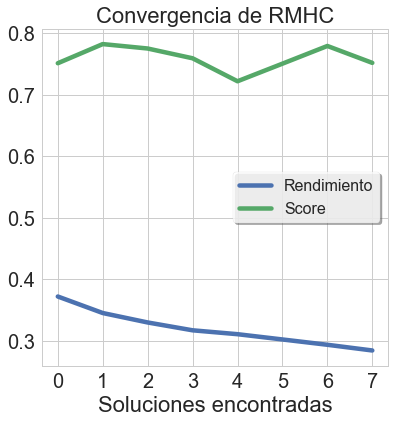

In [39]:
plt.rcParams['figure.figsize']= 6.2,6.2
sns.set_style('whitegrid')

plt.plot(registro_rendimiento_aceptados,label="Rendimiento",linewidth=4.5)
plt.plot(registro_score_valores_aceptados,label="Score",linewidth=4.5)
#plt.ylabel('Score; Rendimiento',fontsize=22)
plt.xlabel('Soluciones encontradas',fontsize=22)


plt.legend(prop={'size':16},frameon=True,shadow=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.title('Convergencia de RMHC',fontsize=22)
plt.show()

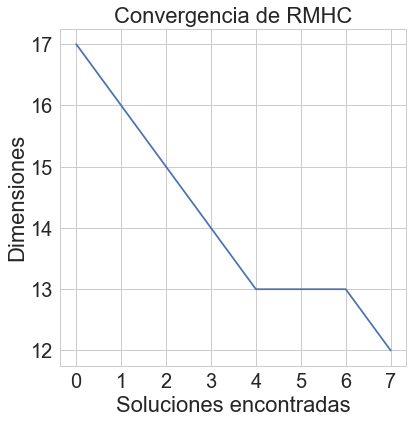

In [40]:
plt.rcParams['figure.figsize']= 6.2,6.2
sns.set_style('whitegrid')

plt.plot(registro_cantidad_dimensiones_activas_aceptados,label="Valores Aceptados")
#plt.ylabel('Score; Rendimiento',fontsize=22)
plt.xlabel('Soluciones encontradas',fontsize=22)
plt.ylabel('Dimensiones',fontsize=22)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.title('Convergencia de RMHC',fontsize=22)
plt.show()

In [15]:
registro_rendimiento_aceptados

[0.36474482100873884, 0.24667635186088804]

In [16]:
registro_score_valores_aceptados

[0.75810672936166434, 0.77585059663753719, 0.76107882713037311]

In [41]:
registro_dimensiones_activas_valores_aceptados

[array([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]),
 array([0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0]),
 array([0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]),
 array([0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0]),
 array([0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]),
 array([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]),
 array([1, 0, 0, 1, 0, 1, 0, 0, 0,

In [ ]:
registro